# Gold Trading Prediction with LSTM (one feature)

What is LSTM?

LSTM = Long Short-Term Memory
LSTM networks are specially designed to remember and process sequences of data over a long period. They are better than traditional RNNs. 
*	Can preserve information for long durations. 
*	Unique structure comprising three gates: the input, forget, and output gates.
*	These gates collaboratively manage the flow of information, deciding what to retain and what to discard, by mitigating the issue of vanishing gradients, a common problem in standard RNNs.

LSTM networks adeptly capture temporal dependencies, making them ideal for financial time series analysis.


In [1]:
# import required libaraies
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# model packages
from sklearn.preprocessing import MinMaxScaler

In [2]:
# download the required data from yfinance
gold_one_day = yf.download('GC=F', start="2024-06-04", end="2024-06-05", interval="1m")
gold_one_year = yf.download('GC=F', period='1y')
gold_ten_year = yf.download('GC=F', period='10y')
print("Gold data are successfully downloaded.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Gold data are successfully downloaded.


## Check the data and statistics of each data frame

In [3]:
# checkout gold data for one day
gold_one_day.head(5)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-06-04 00:00:00-04:00,2366.000000,2366.399902,2365.399902,2365.899902,2365.899902,0
2024-06-04 00:01:00-04:00,2365.899902,2366.300049,2365.600098,2366.100098,2366.100098,199
2024-06-04 00:02:00-04:00,2366.000000,2366.699951,2365.800049,2366.699951,2366.699951,132
2024-06-04 00:03:00-04:00,2366.800049,2366.899902,2366.300049,2366.899902,2366.899902,56
2024-06-04 00:04:00-04:00,2366.800049,2367.100098,2366.800049,2367.000000,2367.000000,86


In [4]:
# checkout gold data for one year
gold_one_year.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-08,1943.199951,1969.000000,1943.099976,1963.599976,1963.599976,433
2023-06-09,1965.099976,1969.800049,1960.300049,1962.199951,1962.199951,49
2023-06-12,1959.699951,1963.500000,1951.400024,1955.300049,1955.300049,212
2023-06-13,1960.599976,1967.500000,1940.300049,1944.599976,1944.599976,343
2023-06-14,1946.199951,1958.199951,1940.300049,1955.300049,1955.300049,202


In [5]:
# checkout gold data for one year
gold_ten_year.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-06-09,1252.699951,1256.099976,1252.599976,1253.500000,1253.500000,97
2014-06-10,1252.400024,1262.300049,1251.000000,1259.800049,1259.800049,1007
2014-06-11,1259.900024,1264.400024,1259.099976,1260.800049,1260.800049,128
2014-06-12,1260.000000,1274.500000,1260.000000,1273.599976,1273.599976,129
2014-06-13,1272.500000,1274.699951,1271.300049,1273.699951,1273.699951,145


## Check out for the missing data 

In [6]:
# check out if there is missing value 
print("Gold data one day")
print(gold_one_day.isna().sum())
print("------------------")
print("Gold data one year")
print(gold_one_year.isna().sum())
print("------------------")
print("Gold data ten years")
print(gold_ten_year.isna().sum())

Gold data one day
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
------------------
Gold data one year
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
------------------
Gold data ten years
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


### There is no missing values!!! Great. Let's start building LSTM model.

Standardize the distributed data in the range of 0 to 1. 

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
gold_one_year_scaled = scaler.fit_transform(gold_one_day['Close'].values.reshape(-1,1))

In [8]:
gold_one_year_scaled

array([[0.84444173],
       [0.85000271],
       [0.86666531],
       ...,
       [0.59166802],
       [0.59166802],
       [0.59444173]])

In [9]:
# check out the scaled data size
gold_one_year_scaled.shape

(1364, 1)

In [10]:
# initialize empty lists
X = []
y = []
# loop to create a 60-day-sequence
for i in range(60, len(gold_one_year_scaled)):
    X.append(gold_one_year_scaled[i-60:i, 0])
    y.append(gold_one_year_scaled[i, 0])

In [11]:
# Train-Test-Split
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
# turn lists to numpy array (2 Dimensional) (#, 60) <60 days sequence>
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
# check the reshaping 
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1043, 60)
y_train shape: (1043,)


In [14]:
# reshaping to train in LSTM model ([samples, time steps, features]) 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [15]:
# check the reshaping 
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1043, 60, 1)
y_train shape: (1043,)


### Now it is ready to train in LSTM model. Let's build one LSTM model to train our data.

In [16]:
# LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

In [17]:
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1))) 
model.add(Reshape((-1, X_train.shape[1])))
# compute attention result 
attention_result = attention([model.output, model.output])
# perform element-wise multiplication of the model's output and the attention result
multiply_layer = Multiply()([model.output, attention_result])
# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())
# Final Dense layer
model.add(Dense(1))

In [18]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
"""Dropout helps in preventing overfitting by randomly setting a fraction of the input 
units to 0 at each update during training, and Batch Normalization stabilizes the learning 
process."""
model.add(Dropout(0.2))
model.add(BatchNormalization())

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
# review the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 permute (Permute)           (None, 50, 60)            0         
                                                                 
 reshape (Reshape)           (None, 50, 60)            0         
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 1)                 3001      
                                                                 
 dropout (Dropout)           (None, 1)                 0

In [21]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

Epoch 1/100
34/34 [==============================] - 4s 49ms/step - loss: 0.3486 - val_loss: 0.0843
Epoch 2/100
34/34 [==============================] - 1s 27ms/step - loss: 0.1951 - val_loss: 0.0672
Epoch 3/100
34/34 [==============================] - 1s 29ms/step - loss: 0.1640 - val_loss: 0.0523
Epoch 4/100
34/34 [==============================] - 1s 25ms/step - loss: 0.1417 - val_loss: 0.0397
Epoch 5/100
34/34 [==============================] - 1s 25ms/step - loss: 0.1218 - val_loss: 0.0310
Epoch 6/100
34/34 [==============================] - 1s 26ms/step - loss: 0.1068 - val_loss: 0.0193
Epoch 7/100
34/34 [==============================] - 1s 26ms/step - loss: 0.0900 - val_loss: 0.0147
Epoch 8/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0751 - val_loss: 0.0094
Epoch 9/100
34/34 [==============================] - 1s 27ms/step - loss: 0.0648 - val_loss: 0.0060
Epoch 10/100
34/34 [==============================] - 1s 27ms/step - loss: 0.0575 - val_loss: 0.0026

In [22]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

9/9 [==============================] - 0s 9ms/step - loss: 7.9027e-04
Test Loss:  0.0007902726647444069


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)


9/9 [==============================] - 1s 8ms/step
Mean Absolute Error:  0.02433693495239385
Root Mean Square Error:  0.028111789713173314


MAE : 1.7 % 

RMSE : 2.1%

In [24]:
# Fetching the latest 60 days of AAPL stock data
test_data = yf.download('GC=F', period='1y')

[*********************100%%**********************]  1 of 1 completed


In [25]:
# check out the first 5 rows
test_data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-08,1943.199951,1969.000000,1943.099976,1963.599976,1963.599976,433
2023-06-09,1965.099976,1969.800049,1960.300049,1962.199951,1962.199951,49
2023-06-12,1959.699951,1963.500000,1951.400024,1955.300049,1955.300049,212
2023-06-13,1960.599976,1967.500000,1940.300049,1944.599976,1944.599976,343
2023-06-14,1946.199951,1958.199951,1940.300049,1955.300049,1955.300049,202


In [26]:
# check out the last 5 rows
test_data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-03,2322.600098,2347.500000,2312.000000,2346.600098,2346.600098,781
2024-06-04,2347.500000,2347.699951,2313.899902,2325.500000,2325.500000,890
2024-06-05,2326.399902,2354.300049,2326.199951,2354.100098,2354.100098,295
2024-06-06,2355.000000,2375.800049,2355.000000,2370.300049,2370.300049,179
2024-06-07,2379.899902,2385.100098,2285.399902,2305.199951,2305.199951,179


### Retrieve test data

In [27]:
# Selecting the 'Close' price and converting to numpy array
closing_prices = test_data['Close'].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 candles
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for tomorrow: ", predicted_stock_price)

1/1 [==============================] - 0s 19ms/step
Predicted Stock Prices for tomorrow:  [[2277.279]]


In [28]:
# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)
    
    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    
    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    
    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Gold Prices for the next 4 days: ", predicted_prices)

1/1 [==============================] - 0s 18ms/step
Predicted Gold Prices for the next 4 days:  [2277.279, 2262.1318, 2244.8167, 2229.701]


# Visualization 

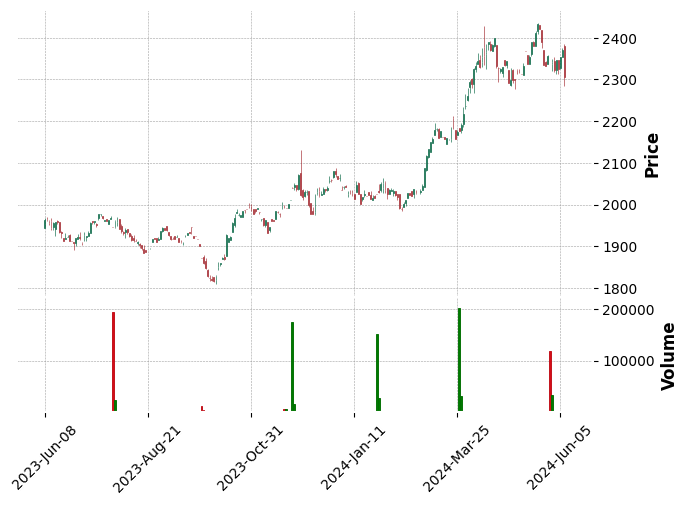

Text(0.5, 1.0, 'Gold Price with Predicted Next 4 Days')

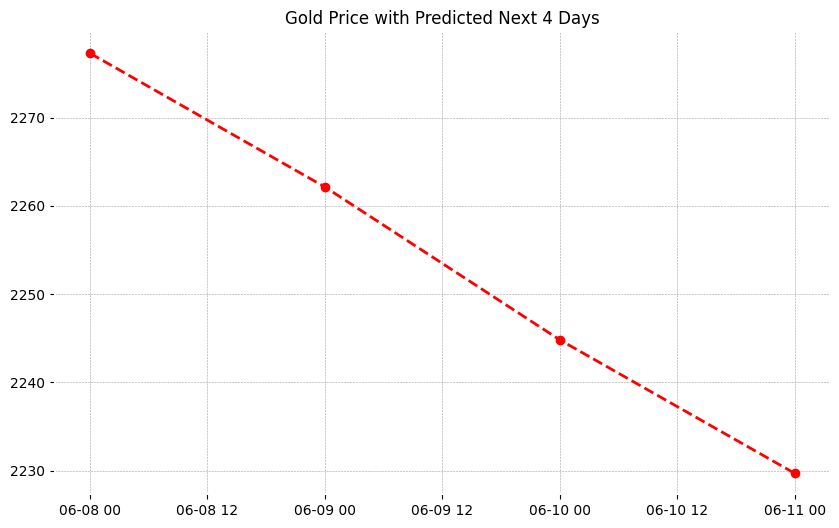

In [29]:
!pip install mplfinance -qqq
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = test_data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(test_data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("Gold Price with Predicted Next 4 Days")

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


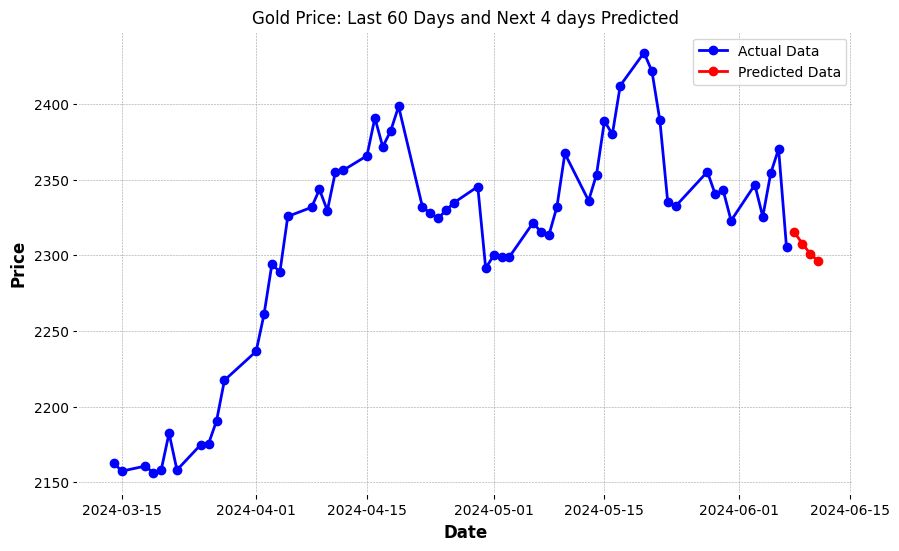

In [30]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('GC=F', period='3mo', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("Gold Price: Last 60 Days and Next 4 days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()